In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

max_images = 200
batch_size = 2048
learning_rate = .001
num_epochs = 25

In [3]:
#GET TARGET DATA

def get_mask(file):
    data = np.load(file)
    bands = data['rad'].reshape(128 * 128, 16)
    cloud_mask = data['l2_cloud_mask'].flatten().reshape(-1, 1)
    return bands, cloud_mask

In [4]:
#CREATE DATASET

file_list = glob.glob('../ABI_Data_Scaled/*.npz')

X = []
y = []

for i, file in enumerate(file_list):
    features, target = get_mask(file)
    X.append(features)
    y.append(target)
    if i == max_images: break

X = torch.from_numpy(np.concatenate(X, axis=0))
y = torch.from_numpy(np.concatenate(y, axis=0)).long().squeeze() #Long for CrossEntropy

dataset = TensorDataset(X, y)

In [5]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#CREATE MODEL

class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim=16, output_dim=2):
        super(FeedForwardClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

num_classes = 2
model = FeedForwardClassifier(output_dim = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    train_loss /= total
    final_acc = correct / total
    return train_loss, final_acc


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    final_acc = correct / total

    return val_loss, final_acc

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 1287/1287 [00:24<00:00, 51.78it/s]


Epoch: 1 | Train Loss: 0.4820 | Train Acc: 0.8431 | Val Loss: 0.2779 | Val Acc: 0.8816


100%|██████████| 1287/1287 [00:24<00:00, 52.10it/s]


Epoch: 2 | Train Loss: 0.2806 | Train Acc: 0.8800 | Val Loss: 0.2831 | Val Acc: 0.8733


100%|██████████| 1287/1287 [00:24<00:00, 51.96it/s]


Epoch: 3 | Train Loss: 0.2737 | Train Acc: 0.8861 | Val Loss: 0.2664 | Val Acc: 0.8957


100%|██████████| 1287/1287 [00:24<00:00, 51.94it/s]


Epoch: 4 | Train Loss: 0.2669 | Train Acc: 0.8906 | Val Loss: 0.3038 | Val Acc: 0.8550


100%|██████████| 1287/1287 [00:24<00:00, 52.34it/s]


Epoch: 5 | Train Loss: 0.2618 | Train Acc: 0.8940 | Val Loss: 0.2518 | Val Acc: 0.9071


100%|██████████| 1287/1287 [00:24<00:00, 52.38it/s]


Epoch: 6 | Train Loss: 0.2534 | Train Acc: 0.8967 | Val Loss: 0.2398 | Val Acc: 0.9082


100%|██████████| 1287/1287 [00:24<00:00, 52.17it/s]


Epoch: 7 | Train Loss: 0.2481 | Train Acc: 0.8977 | Val Loss: 0.2332 | Val Acc: 0.9081


100%|██████████| 1287/1287 [00:24<00:00, 51.97it/s]


Epoch: 8 | Train Loss: 0.2405 | Train Acc: 0.9008 | Val Loss: 0.2240 | Val Acc: 0.9118


100%|██████████| 1287/1287 [00:24<00:00, 51.77it/s]


Epoch: 9 | Train Loss: 0.2327 | Train Acc: 0.9037 | Val Loss: 0.2304 | Val Acc: 0.9038


100%|██████████| 1287/1287 [00:24<00:00, 51.56it/s]


Epoch: 10 | Train Loss: 0.2293 | Train Acc: 0.9045 | Val Loss: 0.2137 | Val Acc: 0.9131


100%|██████████| 1287/1287 [00:24<00:00, 52.05it/s]


Epoch: 11 | Train Loss: 0.2239 | Train Acc: 0.9066 | Val Loss: 0.2122 | Val Acc: 0.9153


100%|██████████| 1287/1287 [00:24<00:00, 52.09it/s]


Epoch: 12 | Train Loss: 0.2192 | Train Acc: 0.9087 | Val Loss: 0.2121 | Val Acc: 0.9142


100%|██████████| 1287/1287 [00:24<00:00, 51.81it/s]


Epoch: 13 | Train Loss: 0.2171 | Train Acc: 0.9092 | Val Loss: 0.2230 | Val Acc: 0.9095


100%|██████████| 1287/1287 [00:24<00:00, 52.11it/s]


Epoch: 14 | Train Loss: 0.2158 | Train Acc: 0.9099 | Val Loss: 0.2079 | Val Acc: 0.9134


100%|██████████| 1287/1287 [00:24<00:00, 52.09it/s]


Epoch: 15 | Train Loss: 0.2148 | Train Acc: 0.9100 | Val Loss: 0.2055 | Val Acc: 0.9135


100%|██████████| 1287/1287 [00:24<00:00, 52.19it/s]


Epoch: 16 | Train Loss: 0.2112 | Train Acc: 0.9112 | Val Loss: 0.2128 | Val Acc: 0.9111


100%|██████████| 1287/1287 [00:24<00:00, 51.72it/s]


Epoch: 17 | Train Loss: 0.2089 | Train Acc: 0.9116 | Val Loss: 0.2421 | Val Acc: 0.8932


100%|██████████| 1287/1287 [00:24<00:00, 51.99it/s]


Epoch: 18 | Train Loss: 0.2051 | Train Acc: 0.9126 | Val Loss: 0.1925 | Val Acc: 0.9167


100%|██████████| 1287/1287 [00:24<00:00, 52.30it/s]


Epoch: 19 | Train Loss: 0.2005 | Train Acc: 0.9142 | Val Loss: 0.2424 | Val Acc: 0.8916


100%|██████████| 1287/1287 [00:24<00:00, 51.95it/s]


Epoch: 20 | Train Loss: 0.1979 | Train Acc: 0.9155 | Val Loss: 0.1901 | Val Acc: 0.9175


100%|██████████| 1287/1287 [00:24<00:00, 51.84it/s]


Epoch: 21 | Train Loss: 0.1952 | Train Acc: 0.9166 | Val Loss: 0.2022 | Val Acc: 0.9131


100%|██████████| 1287/1287 [00:24<00:00, 51.75it/s]


Epoch: 22 | Train Loss: 0.1925 | Train Acc: 0.9179 | Val Loss: 0.2058 | Val Acc: 0.9125


100%|██████████| 1287/1287 [00:24<00:00, 52.07it/s]


Epoch: 23 | Train Loss: 0.1887 | Train Acc: 0.9198 | Val Loss: 0.1828 | Val Acc: 0.9211


100%|██████████| 1287/1287 [00:24<00:00, 51.77it/s]


Epoch: 24 | Train Loss: 0.1859 | Train Acc: 0.9209 | Val Loss: 0.1735 | Val Acc: 0.9285


100%|██████████| 1287/1287 [00:24<00:00, 52.18it/s]


Epoch: 25 | Train Loss: 0.1791 | Train Acc: 0.9239 | Val Loss: 0.1680 | Val Acc: 0.9287


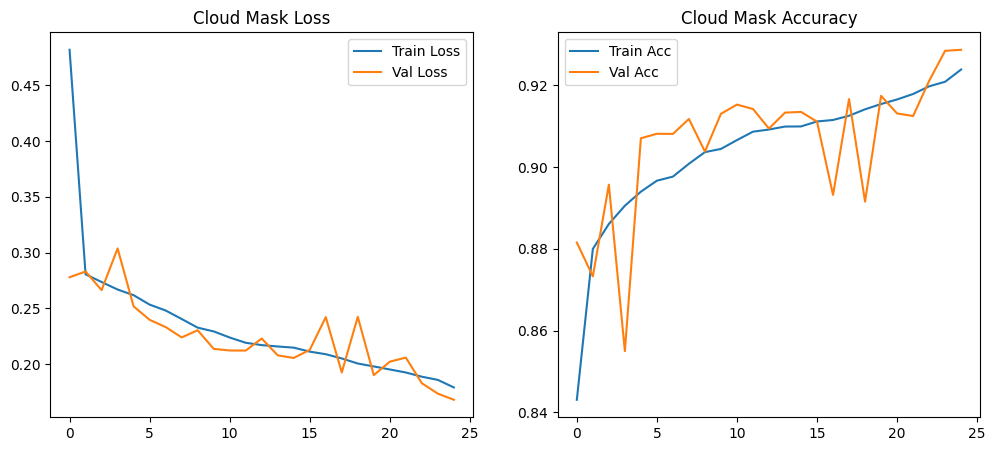

In [9]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Mask Accuracy')
plt.legend()

plt.savefig("./graphs/mlp_cloud_mask.png")  

plt.show()

In [10]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 161/161 [00:02<00:00, 70.43it/s]


REPORT:
               precision    recall  f1-score   support

           0      0.853     0.839     0.846     76239
           1      0.952     0.957     0.954    253080

    accuracy                          0.929    329319
   macro avg      0.903     0.898     0.900    329319
weighted avg      0.929     0.929     0.929    329319

CONFUSION MATRIX:
 [[ 63953  12286]
 [ 10985 242095]]

IOU: [0.73320416 0.91230602]
Unweighted: 0.8227550933084586
Weighted: 0.8708430441747291
